<a href="https://colab.research.google.com/github/knabe-s/lobbytracker_v1_1/blob/main/AK_Entwurf_Lobbytracker_Abfrage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lobbytracker: Abfrage
[Dokumentation](https://github.com/knabe-s/lobbytracker_v1/wiki/Dokumentation---Abfrage)

## Phase 1 - Import des Graphen & Generieren der Node-Listen

In [ ]:
import pprint
from tqdm import tqdm
import numpy as np
import pandas as pd
import networkx as nx
from datetime import datetime
import time

pp = pprint.PrettyPrinter(indent=4)
#pp = pprint.PrettyPrinter(indent=4, sort_dicts=False) #Needs at least Python Version 3.8
hr = "-----"

###Using Github
path_jp = r"/content/"

file_dir = input("Welche Graphdatenbank soll abgefragt werden? (Angabe im Format 'g_YYMMDD-mmHH'): ")
file = "/" + file_dir + ".graphml"
path_nc = r"/Documents/AK_Entwurf_Lobbytracker/" + file_dir
#file = "g_220926-0311" + ".graphml"

nc.get_file(path_nc + file)

F = nx.read_graphml(path_jp + file)driv

###Getting list of all node-ids
graph_nodes = list(F.nodes())

###Generating dicts for norm- and orig-nodes
norm_nodes = pd.DataFrame(columns=["node_id", "bezeichnung"])
orig_nodes = pd.DataFrame(columns=["node_id", "bezeichnung"])

for i in tqdm(range(len(graph_nodes))):
  if "norm" in graph_nodes[i]:
   norm_nodes.at[i, "node_id"] = graph_nodes[i]
   norm_nodes.at[i, "bezeichnung"] = F.nodes[graph_nodes[i]]["bezeichnung"]
  if "orig" in graph_nodes[i]:
   orig_nodes.at[i, "node_id"] = graph_nodes[i]
   orig_nodes.at[i, "bezeichnung"] = F.nodes[graph_nodes[i]]["bezeichnung"]

## Phase 2 - Abfrage

In [ ]:
query = input("Nach welcher Organisation/Entität soll die Datenbank durchsucht werden? ")

first_order_orig_ids = [] #Needed in Phase 6 for generating subgraph
first_order_norm_ids = [] #Needed in Phase 6 for generating subgraph

matches_norm = []
matches_norm_bez = []
matches_orig = []
matches_orig_bez = []



for i in range(len(norm_nodes)):
  if query in norm_nodes.iat[i, 1]:
    matches_norm.append(norm_nodes.iat[i, 0])
    F.nodes[norm_nodes.iat[i, 0]]['node_typ'] = "query_norm"
    F.nodes[norm_nodes.iat[i, 0]]['node_typ_int'] = 3
    matches_norm_bez.append(norm_nodes.iat[i, 1])
    first_order_norm_ids.append(norm_nodes.iat[i, 0])

for i in range(len(orig_nodes)):
  if query in orig_nodes.iat[i, 1]:
    matches_orig.append(orig_nodes.iat[i, 0])
    F.nodes[norm_nodes.iat[i, 0]]['node_typ'] = "query_orig"
    F.nodes[norm_nodes.iat[i, 0]]['node_typ_int'] = 2
    matches_orig_bez.append(orig_nodes.iat[i, 1])
    first_order_orig_ids.append(orig_nodes.iat[i, 0])


Nach welcher Organisation/Entität soll die Datenbank durchsucht werden? SPD Wirtschaftsforum


## Phase 3 - Ausgabe (Treffer)

In [ ]:
###Output: matches
print("Abfrage: '" + query + "'")
print(hr)
print("Treffer in Normalformen: " + str(len(matches_norm)))
pp.pprint(matches_norm_bez)
print(hr)
print("Treffer in Originalformen: " + str(len(matches_orig)))
pp.pprint(matches_orig_bez)


matches_norm_edges = []
for i in range(len(matches_norm)):
  matches_norm_edges.append(list(F.edges(matches_norm[i])))

for i in range(len(matches_norm_edges)):
  #print("matches_norm_edges[i]: " + str(matches_norm_edges[i]))
  edge_pair = matches_norm_edges[i]
  for c in range(len(edge_pair)):
    edge_pair_tmp = edge_pair[c]
    #print(edge_pair_tmp)
    first_order_orig_ids.append(edge_pair_tmp[1])

###Removing duplicate orig-node-ids
first_order_orig_ids = list(set(first_order_orig_ids))

Abfrage: 'SPD Wirtschaftsforum'
-----
Treffer in Normalformen: 3
[   'SPD Wirtschaftsforum',
    'SPD Wirtschaftsforum e.V.',
    'SPD Wirtschaftsforum e. V.']
-----
Treffer in Originalformen: 3
[   'SPD Wirtschaftsforum',
    'SPD Wirtschaftsforum e.V.',
    'SPD Wirtschaftsforum e. V.']


## Phase 4 - Ausgabe (Inhalte der direkten Treffer - 1ter Ordnung)

In [ ]:
###Generating subgraph for all direct matches
F_first_order = F.subgraph(first_order_orig_ids)

###Printing all attributes of all direct matches
for n in F_first_order.nodes():
  first_order_output = F_first_order.nodes[n]
  pp.pprint(first_order_output)

{   'bezeichnung': 'SPD Wirtschaftsforum e.V.',
    'id': '0011499',
    'letzte_akt': '2022-03-01',
    'node_typ': 'orig',
    'node_typ_int': 0,
    'quelle': 'lobbyregister',
    'typ': 'lobbyregister_membership'}
{   'bezeichnung': 'SPD Wirtschaftsforum',
    'id': '0011497',
    'letzte_akt': '2022-02-22',
    'node_typ': 'orig',
    'node_typ_int': 0,
    'quelle': 'lobbyregister',
    'typ': 'lobbyregister_membership'}
{   'bezeichnung': 'SPD Wirtschaftsforum e. V.',
    'id': '0011500',
    'letzte_akt': '2022-05-09',
    'node_typ': 'orig',
    'node_typ_int': 0,
    'quelle': 'lobbyregister',
    'typ': 'lobbyregister_membership'}


## Phase 5 - Ausgabe (Inhalte der indirekten Treffer - 2ter Ordnung)

In [ ]:
edgelist_graph = list(F.edges.data("edge_typ"))

second_order_orig_ids = []
second_order_norm_ids = []

indirect_client_source = []
indirect_client_source_norm = []
indirect_client_target = []
indirect_client_target_norm = []
indirect_memberships_source = []
indirect_memberships_source_norm = []
indirect_memberships_target = []
indirect_memberships_target_norm = []
clients_of = []
client = []
member_in = []
memberships = []


for i in range(len(first_order_orig_ids)):
  for (u, v, t) in F.edges.data("edge_typ"):
    if "Auftraggeber" in F.edges[u, v]["edge_typ"]:
      if first_order_orig_ids[i] == u:
        indirect_client_source.append(v)
      if first_order_orig_ids[i] == v:
        indirect_client_target.append(u)
        
    if "Mitglied" in F.edges[u, v]["edge_typ"]:
      if first_order_orig_ids[i] == u:
        indirect_memberships_source.append(v)
      if first_order_orig_ids[i] == v:
        indirect_memberships_target.append(u)


for i in range(len(indirect_client_source)):
  clients_of.append(orig_nodes.loc[orig_nodes['node_id'] == indirect_client_source[i]])
  second_order_orig_ids.append(indirect_client_source[i])
for i in range(len(indirect_client_target)):
  client.append(orig_nodes.loc[orig_nodes['node_id'] == indirect_client_target[i]])
  second_order_orig_ids.append(indirect_client_target[i])
for i in range(len(indirect_memberships_source)):
  member_in.append(orig_nodes.loc[orig_nodes['node_id'] == indirect_memberships_source[i]])
  second_order_orig_ids.append(indirect_memberships_source[i])
for i in range(len(indirect_memberships_target)):
  memberships.append(orig_nodes.loc[orig_nodes['node_id'] == indirect_memberships_target[i]])
  second_order_orig_ids.append(indirect_memberships_target[i])


for (u, v, t) in F.edges.data("edge_typ"):
  if "Normalform" in F.edges[u, v]["edge_typ"]:

    for i in range(len(indirect_client_source)):
      if v == indirect_client_source[i]:
        df = norm_nodes.loc[norm_nodes["node_id"] == u]
        second_order_norm_ids.append(u)
        nda = df["bezeichnung"].unique()
        norm_bez = np.array2string(nda)
        indirect_client_source_norm.append(norm_bez)

    for i in range(len(indirect_client_target)):
      if v == indirect_client_target[i]:
        df = norm_nodes.loc[norm_nodes["node_id"] == u]
        second_order_norm_ids.append(u)
        nda = df["bezeichnung"].unique()
        norm_bez = np.array2string(nda)
        indirect_client_target_norm.append(norm_bez)

    for i in range(len(indirect_memberships_source)):
      if v == indirect_memberships_source[i]:
        df = norm_nodes.loc[norm_nodes["node_id"] == u]
        second_order_norm_ids.append(u)
        nda = df["bezeichnung"].unique()
        norm_bez = np.array2string(nda)
        indirect_memberships_source_norm.append(norm_bez)

    for i in range(len(indirect_memberships_target)):
      if v == indirect_memberships_target[i]:
        df = norm_nodes.loc[norm_nodes["node_id"] == u]
        second_order_norm_ids.append(u)
        nda = df["bezeichnung"].unique()
        norm_bez = np.array2string(nda)
        indirect_memberships_target_norm.append(norm_bez)    

indirect_client_source_norm = list(set(indirect_client_source_norm))
indirect_client_target_norm = list(set(indirect_client_target_norm))
indirect_memberships_source_norm = list(set(indirect_memberships_source_norm))
indirect_memberships_target_norm = list(set(indirect_memberships_target_norm))


print(hr + hr)
print(query + " ist Auftraggeber von: " + str(len(indirect_client_source_norm)))
print(indirect_client_source_norm)
print(hr)
print("Folgende sind Auftraggeber von " + query + ": " + str(len(indirect_client_target_norm)))
print(indirect_client_target_norm)
print(hr)
print(query + " ist Mitglied in: " + str(len(indirect_memberships_source_norm)))
print(indirect_memberships_source_norm)
print(hr)
print("Folgende sind Mitglied in " + query + ": " + str(len(indirect_memberships_target_norm)))
print(indirect_memberships_target_norm)


----------
SPD Wirtschaftsforum ist Auftraggeber von: 0
[]
-----
Folgende sind Auftraggeber von SPD Wirtschaftsforum: 0
[]
-----
SPD Wirtschaftsforum ist Mitglied in: 0
[]
-----
Folgende sind Mitglied in SPD Wirtschaftsforum: 9
["['Verband der Universitätsklinika Deutschlands (VUD)']", "['VIK Verband der Industriellen Energie- und Kraftwirschaft e.V.']", "['Bundesverband der Zigarrenindustrie e.V.']", "['SAP SE']", "['Edenred Deutschland']", "['Bayer AG']", "['BASF SE']", "['TIER Mobility SE']", "['TenneT TSO GmbH']"]


## Phase 6 - Speichern und Zeichnen der Abfrage

In [ ]:
query_node_ids = first_order_norm_ids + first_order_orig_ids + second_order_norm_ids + second_order_orig_ids
query_node_ids = list(set(query_node_ids))
#print(len(query_node_ids))

Q = F.subgraph(query_node_ids)
Q.graph['name'] = "q_" + str(datetime.now().strftime('%y%m%d-%H%M'))
Q.graph['Abfrage'] = query

###Saving query-subgraph as graphml
nx.write_graphml(Q, path_jp + Q.graph['name'] + '.graphml', encoding='utf-8')
out_graphml = Q.graph['name'] + '.graphml'
nc.put_file(path_nc + out_graphml, path_jp + out_graphml)


True

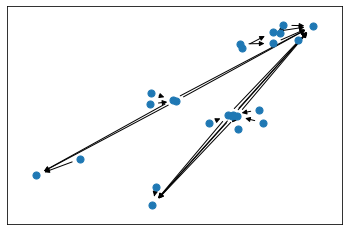

In [ ]:
val_map = {""}

pos = nx.spring_layout(Q)
nx.draw_networkx_nodes(Q, pos, cmap=plt.get_cmap('jet'), node_size = 50)
#nx.draw_networkx_labels(Q, pos)
nx.draw_networkx_edges(Q, pos, edge_color='black', arrows=True)
plt.show()

## Ablage

In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
print("Graph: " + F.graph['name'])
print("Importierte Normalformen: " + F.graph['files_norm'])
print("Importierte Originalformen: " + F.graph['files_orig'])
print("-------------")

###Number of nodes:
tmp_nodes = list(F)
tmp_count_nodes_all = len(tmp_nodes)

####Count norm-nodes
tmp_count_nodes_norm, tmp_count_nodes_orig = 0, 0
for tmp_i in range(len(tmp_nodes)):
  if str(tmp_nodes[tmp_i]).startswith("norm") == True:
    tmp_count_nodes_norm = tmp_count_nodes_norm + 1
  elif str(tmp_nodes[tmp_i]).startswith("orig") == True:
    tmp_count_nodes_orig = tmp_count_nodes_orig + 1

tmp_out_count_node = "Knoten: " + str(tmp_count_nodes_all)
tmp_out_count_nodes_norm = "Normalformen (" + str(tmp_count_nodes_norm) + ")"
tmp_out_count_nodes_orig = "Originalformen (" + str(tmp_count_nodes_orig) + ")"

print(tmp_out_count_node + " - " + tmp_out_count_nodes_norm + " & " + tmp_out_count_nodes_orig)

###Number of edges
tmp_edges = F.edges()
tmp_count_edges = len(tmp_edges)

edgelist = nx.to_pandas_edgelist(F)

edges_values = edgelist['edge_typ'].value_counts()
edges_values_dict = edges_values.to_dict()
print("Kanten: " + str(tmp_count_edges) + " - 'Normalform von' (" + str(edges_values_dict["ist die Normalform von"]) + "), 'Auftraggeber von' (" + str(edges_values_dict["ist ein Auftraggeber von"]) + ") & 'Mitglied in' (" + str(edges_values_dict["ist ein Mitglied in"]) + ")")

### Resetting temporary variables
%reset_selective -f tmp

Graph: q_221026-1302
Importierte Normalformen: ['2022-09-20_norm.csv']
Importierte Originalformen: ['2022-09-20_orig_lobbyisten.csv', '2022-09-20_orig_mitgliedschaften.csv', '2022-09-20_orig_auftraggeber.csv']
-------------
Knoten: 46232 - Normalformen (25388) & Originalformen (20844)
Kanten: 77587 - 'Normalform von' (20844), 'Auftraggeber von' (1897) & 'Mitglied in' (54846)
